
[**Task 1**](#task1): Exploratory Data Analysis

[**Task 2**](#task2): Visualizing Geographical Data

[**Task 3**](#task3): K-Means Clustering

[**Task 4**](#task4): DBSCAN

[**Task 5**](#task5): HDBSCAN

[**Task 6**](#task6): Addressing Outliers



In [117]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

<a id='task1'></a>
# Task 1: Exploratory Data Analysis

In [118]:
df=pd.read_csv('taxi_data.csv')

In [119]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [120]:
df.duplicated(subset=['LON','LAT']).values.any()

True

In [121]:
df.isna().values.any()

True

In [122]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LAT','LON'],keep='first',inplace=True)

print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [123]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [124]:
x=np.array(df[['LON','LAT']],dtype='float64')

In [125]:
x

array([[ 28.17858, -25.73882],
       [ 28.1766 , -25.73795],
       [ 27.83239, -26.53722],
       ...,
       [ 27.83991, -26.24235],
       [ 27.86166, -26.23624],
       [ 28.39097, -26.30931]])

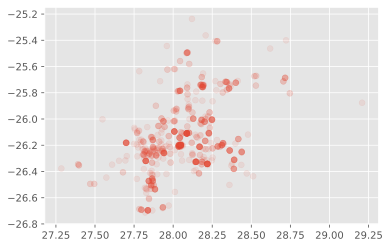

In [126]:
plt.scatter(x[:,0],x[:,1],alpha=0.1)

<a id='task2'></a>
# Task 2: Visualizing Geographical Data


In [127]:
_map=folium.Map(location=[df['LAT'].mean(),df['LON'].mean()],zoom_start=10,tiles='Stamen Toner')
RADIUS=5
for index,row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT,row.LON],
        radius=RADIUS,
        popup=re.sub(r'[^a-zA-Z ]+'," ",row.NAME),
        color='#1787ef',
        fill=True,
        fill_color='#1787ef'
    ).add_to(_map)

In [128]:
_map

<a id='task3'></a>
# Task 3: K-Means Clustering

In [172]:
k=70
kmmodel=KMeans(n_clusters=k,random_state=17).fit(x)
cluster_predictions=kmmodel.predict(x)
df[f'CLUSTER_kmeans{k}']=cluster_predictions

In [173]:
df

LON       LAT                          NAME  CLUSTER_kmeans20  \
0    28.17858 -25.73882         11th Street Taxi Rank                 1   
1    28.17660 -25.73795    81 Bazaar Street Taxi Rank                 1   
2    27.83239 -26.53722          Adams Road Taxi Rank                16   
3    28.12514 -26.26666  Alberton City Mall Taxi Rank                 7   
4    28.10144 -26.10567      Alexandra Main Taxi Rank                18   
..        ...       ...                           ...               ...   
832  28.04441 -26.19727            Zimbabwe Taxi Rank                 0   
833  27.82999 -26.24445         Zola Clinic Taxi Rank                 5   
834  27.83991 -26.24235                Zola Taxi Rank                 5   
835  27.86166 -26.23624               Zondi Taxi Rank                 6   
836  28.39097 -26.30931            kwaThema Taxi Rank                19   

     CLUSTER_DBSCAN  CLUSTER_hdbscan  CLUSTER_hybrid  CLUSTER_kmeans70  
0                 0               19              19                15  
1                 0               19              19                15  
2                -1               -1              26                 5  
3                -1               -1              41                33  
4                 1               55              55                18  
..              ...              ...             ...               ...  
832               9               53              53                 7  
833              25               63              63                 1  
834              -1               63              63                 1  
835              -1               65              65                49  
836              19               14              14                10  

[823 rows x 8 columns]

In [174]:
def create_map(df,cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        if row[cluster_column]==-1:
            cluster_colour='#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row.LAT,row.LON],
            radius=5,
            popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
    return m
m=create_map(df,'CLUSTER_kmeans20')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(x, cluster_predictions)}')

_map.save('kmeans_20.html')

K=70
Silhouette Score: 0.6367300948961482


In [175]:
m

In [133]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(x)
    class_predictions = model.predict(x)
    
    curr_silhouette = silhouette_score(x, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████| 98/98 [00:20<00:00,  4.88it/s]

K=98
Silhouette Score: 0.6971995093340411


<a id='task4'></a>
# Task 4: DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [134]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1,-1])
new =np.array([(counter+2)*x if x==-1 else x for counter,x in enumerate(dummy)])
new

array([ -2,  -3,  -4,   2,   3,   4,   5,  -9, -10])

In [135]:
dbmodel=DBSCAN(eps=0.01,min_samples=5).fit(x)
cluster_predictions=dbmodel.labels_
df['CLUSTER_DBSCAN']=cluster_predictions

In [136]:
m=create_map(df,'CLUSTER_DBSCAN')
print(f'Number of clusters found: {len(np.unique(cluster_predictions))}')
print(f'Number of outliers found: {len(class_predictions[cluster_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(x[cluster_predictions!=-1], cluster_predictions[cluster_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(x, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138250288208
Silhouette outliers as singletons: 0.6971082963940812


In [137]:
m

<a id='task5'></a>
# Task 5: HDBSCAN
Hierarchical DBSCAN

In [138]:
model=hdbscan.HDBSCAN(min_samples=2,min_cluster_size=5,cluster_selection_epsilon=0.01)

cluster_predictions=model.fit_predict(x)
df['CLUSTER_hdbscan']=cluster_predictions
# df['CLUSTER_hdbscan'].dtype

In [139]:
m=create_map(df,'CLUSTER_hdbscan')
print(f'Number of clusters found: {len(np.unique(cluster_predictions))-1}')
print(f'Number of outliers found: {len(cluster_predictions[cluster_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(x[cluster_predictions!=-1], cluster_predictions[cluster_predictions!=-1])}')

no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(x, no_outliers)}')

m

Number of clusters found: 66
Number of outliers found: 102
Silhouette ignoring outliers: 0.7670504356844786
Silhouette outliers as singletons: 0.6971082963940812


<a id='task6'></a>
# Task 6: Addressing Outliers


In [140]:
classifier=KNeighborsClassifier(n_neighbors=1)

In [141]:
df_train=df[df.CLUSTER_hdbscan!=-1]
df_predict=df[df.CLUSTER_hdbscan==-1]

In [150]:
x_train=np.array(df_train[['LON','LAT']],dtype='float64')
y_train=np.array(df_train['CLUSTER_hdbscan'],dtype='int64')

x_predict=np.array(df_predict[['LON','LAT']],dtype='float64')


In [151]:
classifier.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [152]:
y_predict=classifier.predict(x_predict)

In [156]:
df['CLUSTER_hybrid']=df['CLUSTER_hdbscan']

In [157]:
df.loc[df.CLUSTER_hdbscan==-1, 'CLUSTER_hybrid']=y_predict

In [158]:
m=create_map(df,'CLUSTER_hybrid')

In [159]:
m

In [171]:
class_predictions=df.CLUSTER_hybrid
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(x, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126494706486


Text(0.5, 1.0, 'compare kmeans70 vs hdbscan')

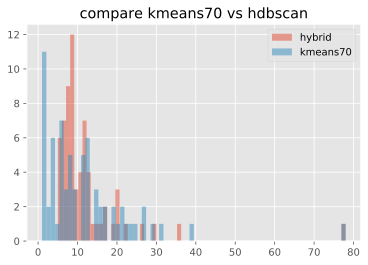

In [178]:
df['CLUSTER_hybrid'].value_counts().hist(bins=70,alpha=0.5,label='hybrid')
df['CLUSTER_kmeans70'].value_counts().hist(bins=70,alpha=0.5,label='kmeans70')

plt.legend()
plt.title('compare kmeans70 vs hdbscan')